In [34]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import gzip

In [35]:
# Download training data from open datasets.
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

In [36]:
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

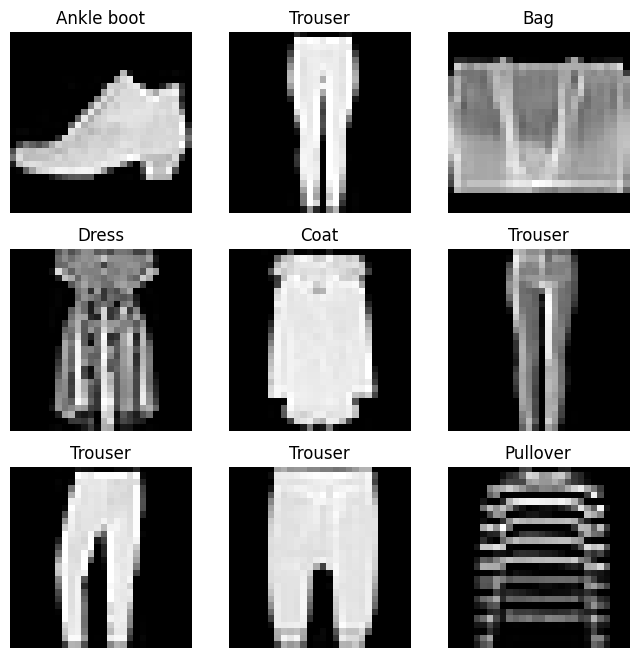

In [35]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(classes[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [36]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


In [37]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "cpu"
)
print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

Using cpu device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [38]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [39]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [40]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [41]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.306957  [   64/60000]
loss: 2.296147  [ 6464/60000]
loss: 2.273746  [12864/60000]
loss: 2.266272  [19264/60000]
loss: 2.250971  [25664/60000]
loss: 2.217182  [32064/60000]
loss: 2.228909  [38464/60000]
loss: 2.195453  [44864/60000]
loss: 2.188948  [51264/60000]
loss: 2.160021  [57664/60000]
Test Error: 
 Accuracy: 42.7%, Avg loss: 2.155762 

Epoch 2
-------------------------------
loss: 2.167244  [   64/60000]
loss: 2.161547  [ 6464/60000]
loss: 2.097712  [12864/60000]
loss: 2.116953  [19264/60000]
loss: 2.079131  [25664/60000]
loss: 2.011789  [32064/60000]
loss: 2.039007  [38464/60000]
loss: 1.964299  [44864/60000]
loss: 1.955008  [51264/60000]
loss: 1.901619  [57664/60000]
Test Error: 
 Accuracy: 59.4%, Avg loss: 1.893165 

Epoch 3
-------------------------------
loss: 1.921449  [   64/60000]
loss: 1.903921  [ 6464/60000]
loss: 1.772288  [12864/60000]
loss: 1.819563  [19264/60000]
loss: 1.727786  [25664/60000]
loss: 1.663390  [32064/600

In [52]:
torch.save(model.state_dict(), f"../models/fashion-mnist-{device}.pth")
print(f"Saved PyTorch Model State to ../models/fashion-mnist-{device}.pth")

Saved PyTorch Model State to ../models/fashion-mnist-cpu.pth


In [38]:
model = NeuralNetwork().to(device)
model.load_state_dict(torch.load(f"../models/fashion-mnist-{device}.pth"))

<All keys matched successfully>

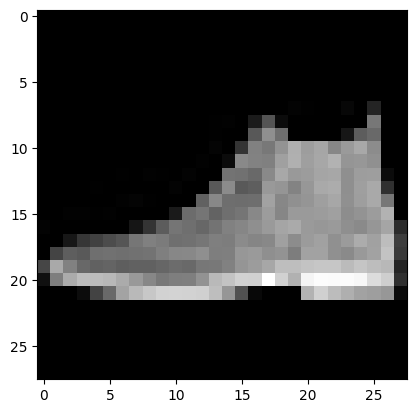

Predicted: "Ankle boot", Actual: "Ankle boot"


In [39]:
model.eval()
x, y = test_data[0][0], test_data[0][1]

plt.imshow(x.squeeze(), cmap="gray")
plt.show()

with torch.no_grad():
    x = x.to(device)
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

In [64]:
save_image(x, "../data/fashion-mnist/0.png")

In [40]:
print(f"Shape of input image: {x.shape}")
print(f"Input image center: {x[:,12:16,12:16]}")

Shape of input image: torch.Size([1, 28, 28])
Input image center: tensor([[[0.0000, 0.0000, 0.4510, 0.4471],
         [0.0000, 0.3490, 0.5451, 0.3529],
         [0.3843, 0.5333, 0.4314, 0.4275],
         [0.4588, 0.3882, 0.4353, 0.4588]]])


In [41]:
flat_image = model.flatten(x)
flat_image_center = torch.stack((
    flat_image[:,348:352][0],
    flat_image[:,376:380][0],
    flat_image[:,404:408][0],
    flat_image[:,432:436][0]))
print(f"Shape of flat image: {flat_image.shape}")
print(f"Flat image center: {flat_image_center}")

Shape of flat image: torch.Size([1, 784])
Flat image center: tensor([[0.0000, 0.0000, 0.4510, 0.4471],
        [0.0000, 0.3490, 0.5451, 0.3529],
        [0.3843, 0.5333, 0.4314, 0.4275],
        [0.4588, 0.3882, 0.4353, 0.4588]])


In [51]:
layer0_weight = model.get_parameter("linear_relu_stack.0.weight")
layer0_bias = model.get_parameter("linear_relu_stack.0.bias")

print(f"layer 0 weight - Shape: {layer0_weight.shape} - {layer0_weight}\n")
print(f"layer 0 bias - Shape: {layer0_bias.shape} - {layer0_bias}")

layer 0 weight - Shape: torch.Size([512, 784]) - Parameter containing:
tensor([[-0.0316,  0.0203, -0.0332,  ...,  0.0287,  0.0063, -0.0015],
        [ 0.0030,  0.0021,  0.0107,  ...,  0.0305,  0.0074,  0.0257],
        [ 0.0195,  0.0005,  0.0293,  ..., -0.0194,  0.0107, -0.0193],
        ...,
        [-0.0316, -0.0213,  0.0045,  ...,  0.0125,  0.0346,  0.0092],
        [-0.0156,  0.0292,  0.0254,  ..., -0.0122,  0.0304,  0.0205],
        [ 0.0047,  0.0334, -0.0260,  ...,  0.0213,  0.0197,  0.0137]],
       requires_grad=True)

layer 0 bias - Shape: torch.Size([512]) - Parameter containing:
tensor([-7.9807e-03,  3.7850e-02, -5.6222e-03,  4.1647e-02,  2.9742e-02,
        -1.3576e-02,  1.4436e-02, -1.9516e-02,  4.4971e-03, -5.7161e-03,
        -4.8008e-05,  1.2640e-02, -1.0890e-02,  1.2012e-02, -1.4001e-02,
         1.4286e-02, -2.8406e-02,  5.9529e-04,  7.1454e-03,  2.7426e-02,
         4.3445e-03, -1.3603e-02, -3.1620e-03,  1.9660e-02, -1.7421e-02,
        -2.5235e-02, -2.0332e-02, -2.9

In [52]:
layer0 = model.linear_relu_stack[0]
hidden0 = layer0(flat_image)

print(f"Shape of hidden 0: {hidden0.shape}")
print(f"Hidden 0: {hidden0}")

Shape of hidden 0: torch.Size([1, 512])
Hidden 0: tensor([[ 1.4283e-01,  2.3861e-01,  1.5658e-01,  8.1019e-01, -1.0705e-01,
         -1.3241e-01,  2.9280e-02,  5.5731e-01,  9.7973e-02,  3.5544e-01,
         -2.2557e-02, -1.9903e-02, -9.5038e-02,  5.3382e-01, -1.2705e-01,
         -2.5710e-01,  4.8025e-02, -1.1102e-01, -1.2339e-01, -1.7444e-01,
         -2.0406e-01,  9.0820e-01, -8.6238e-02, -3.9587e-02,  3.0394e-02,
          2.0616e-01, -2.0521e-01, -2.0352e-02,  1.5131e-01,  2.8989e-01,
         -1.0019e-01, -5.5283e-02, -7.0079e-02, -8.9302e-03,  1.9326e-01,
         -4.3389e-02,  4.3539e-01,  7.0436e-02,  9.0940e-01, -2.3837e-01,
         -1.4166e-01,  2.6791e-01,  1.3133e-01,  7.1302e-01,  1.9234e-01,
         -6.5167e-02, -2.6286e-01,  2.3614e-01, -1.0577e-02,  3.7570e-01,
          7.6032e-01,  1.1558e+00,  6.5835e-01,  1.0390e+00, -2.0974e-01,
          2.3509e-01, -3.0702e-01, -9.7780e-02, -3.3016e-01,  6.9580e-02,
          5.7457e-01,  2.8545e-01,  3.0023e-01,  3.4726e-02, -

In [53]:
torch.set_printoptions(precision=15)
print(hidden0[0][0])
print(flat_image @ layer0_weight[0] + layer0_bias[0])
torch.set_printoptions(precision=4)

tensor(0.142832264304161, grad_fn=<SelectBackward0>)
tensor([0.142832264304161], grad_fn=<AddBackward0>)


In [54]:
with (
  torch.no_grad(),
  gzip.GzipFile("../models/fashion-mnist/layer0-weight.gz", mode="wb") as f
):
    f.write(layer0_weight.cpu().numpy().tobytes())

In [55]:
with (
  torch.no_grad(),
  gzip.GzipFile("../models/fashion-mnist/layer0-bias.gz", mode="wb") as f
):
    f.write(layer0_bias.cpu().numpy().tobytes())

In [56]:
layer1 = model.linear_relu_stack[1]
hidden1 = layer1(hidden0)

print(f"Shape of hidden 1: {hidden1.shape}")
print(f"Hidden 1: {hidden1}")

Shape of hidden 1: torch.Size([1, 512])
Hidden 1: tensor([[1.4283e-01, 2.3861e-01, 1.5658e-01, 8.1019e-01, 0.0000e+00, 0.0000e+00,
         2.9280e-02, 5.5731e-01, 9.7973e-02, 3.5544e-01, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 5.3382e-01, 0.0000e+00, 0.0000e+00, 4.8025e-02, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 9.0820e-01, 0.0000e+00, 0.0000e+00,
         3.0394e-02, 2.0616e-01, 0.0000e+00, 0.0000e+00, 1.5131e-01, 2.8989e-01,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.9326e-01, 0.0000e+00,
         4.3539e-01, 7.0436e-02, 9.0940e-01, 0.0000e+00, 0.0000e+00, 2.6791e-01,
         1.3133e-01, 7.1302e-01, 1.9234e-01, 0.0000e+00, 0.0000e+00, 2.3614e-01,
         0.0000e+00, 3.7570e-01, 7.6032e-01, 1.1558e+00, 6.5835e-01, 1.0390e+00,
         0.0000e+00, 2.3509e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 6.9580e-02,
         5.7457e-01, 2.8545e-01, 3.0023e-01, 3.4726e-02, 0.0000e+00, 9.7871e-03,
         1.8171e-01, 7.2522e-02, 0.0000e+00, 1.4050e-01, 0.